# Table of Contents
 <p><div class="lev2"><a href="#問題"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>問題</a></div><div class="lev2"><a href="#最小二乗法"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>最小二乗法</a></div><div class="lev2"><a href="#ベイズ推定"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>ベイズ推定</a></div><div class="lev2"><a href="#経験ベイズ"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>経験ベイズ</a></div>

## 問題

$y=ax+\varepsilon$

$\varepsilon\sim N(0, \sigma^2)$は誤差項

$a$を推定したい

$Y,X\in R^{N}$:観測データ(データ数$N$)

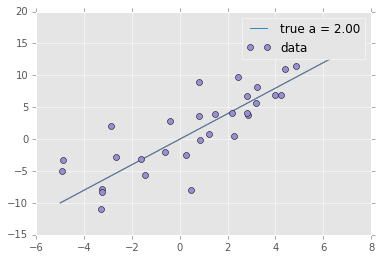

In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# seed = 0
# np.random.seed(seed)

a_orig = 2.
sigma_orig = 5.0

xs = np.linspace(-5, 7, 1000)
ys = a_orig * xs

num_data = 30
data_x = np.random.uniform(-5, 5, num_data)
data_y = a_orig * data_x + np.random.normal(0, sigma_orig, num_data)

plt.plot(xs, ys)
plt.scatter(data_x, data_y)

plt.plot(xs, ys, label='true a = %.2f'%(a_orig))
plt.plot(data_x, data_y, 'o', label='data')
plt.legend()

## 最小二乗法
誤差二乗和を最小にするパラメーター$a$を求める

$\hat{a}=\mathrm{argmin}_a|Y-aX|_2=\mathrm{argmin}_a\sum_i (Y_i-aX_i)^2$


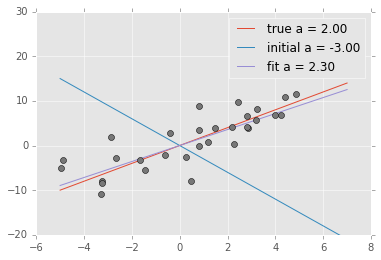

In [31]:
from scipy.optimize import least_squares

def calc_residuals(params, data_x, data_y):
    model_y = params[0] * data_x
    return model_y - data_y

a_init = -3
res = least_squares(calc_residuals, np.array([a_init]), args=(data_x, data_y))

a_least_squares = res.x[0]
ys_fit = a_least_squares * xs
ys_init = a_init * xs

plt.plot(xs, ys, label='true a = %.2f'%(a_orig))
plt.plot(xs, ys_init, label='initial a = %.2f'%(a_init))
plt.plot(xs, ys_fit, label='fit a = %.2f'%(a_fit))
plt.plot(data_x, data_y, 'o')
plt.ylim(-20, 30)
plt.legend()

## ベイズ推定

観測データ$D=\{X,Y\}$とおく。


$P(a|D)\propto P(D|a) P(a)$

$a$についての事前分布として正規分布を仮定する。

$P(a|\mu_{a0}, S_{a0})$

$P(D|a)=P(D| Y-aX, \beta^{-1} )$


$\beta = \frac{1}{\sigma^2}$

$\mu_{a0},\sigma^2_{a0},\beta$は既知とすると

$P(a|D)=P(a| \mu_{aN}  ,\sigma_{aN})$

$\mu_{aN} =  \sigma_{aN}^2 (\frac{1}{\sigma^2_{a0}}\mu_{a0} + \beta X^T Y)$

$ \frac{1}{\sigma_{aN}^2}=   \frac{1}{\sigma_{a0}^2} + \beta X^T X  $

$\sigma_{aN}^2 = \frac{1 + \sigma_{a0}^2 \beta X^T X }{\sigma_{a0}^2}$

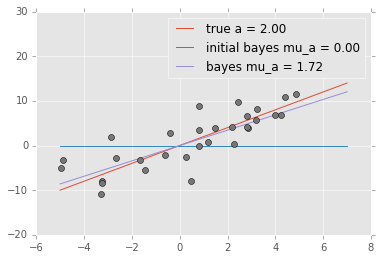

In [62]:
mu_a0 = 0
sigma_a0_2 = 1.0
beta_orig = 0.1
sigma_aN_2 =   sigma_a0_2 /  ( 1 + sigma_a0_2 * beta_orig  *   np.dot(data_x, data_x)  )
mu_aN = sigma_aN_2 * ( mu_a0 / sigma_a0_2 + beta_orig * np.dot(data_x, data_y)) 

ys_init_bayes = mu_a0 * xs
ys_bayes = mu_aN * xs

plt.plot(xs, ys, label='true a = %.2f'%(a_orig))
plt.plot(xs, ys_init_bayes, label='initial bayes mu_a = %.2f'%(mu_a0))
plt.plot(xs, ys_bayes, label='bayes mu_a = %.2f'%(mu_aN))
plt.plot(data_x, data_y, 'o')
plt.ylim(-20, 30)
plt.legend()

## 経験ベイズ
$\alpha=\frac{\gamma}{m_N^Tm_N}$

$\gamma=\sum_i^M \frac{\lambda_i}{\alpha+\lambda_i}$

$(\beta \Phi^T \Phi) u_i = \lambda_i u_i$

$\Phi = X$

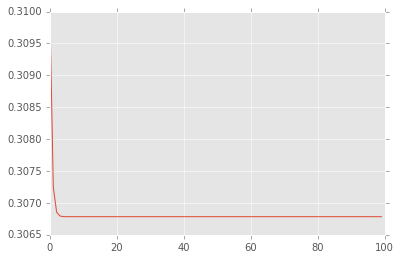

In [63]:
beta_before = beta_orig
alpha_before = sigma_a0_2
m_N = mu_aN
lambda_0 = beta_orig * np.dot(data_x, data_x)
gamma = lambda_0 / (alpha_before + lambda_0)
alpha_next = gamma / (m_N  * m_N)
beta_next =  (num_data - gamma) / (np.linalg.norm(data_y -   m_N * data_x)**2)

n_iter = 100
alpha_hist = np.zeros(n_iter) 
beta_hist = np.zeros(n_iter) 

for i in range(n_iter):
    beta_before = beta_next
    alpha_before = alpha_next
    m_N_before = m_N
    sigma_aN_2 =   alpha_before /  ( 1 + alpha_before * beta_before *   np.dot(data_x, data_x)  )
    m_N = sigma_aN_2 * ( m_N_before / alpha_before + beta_before * np.dot(data_x, data_y)) 
    lambda_0 = beta_before * np.dot(data_x, data_x)
    gamma = lambda_0 / (alpha_before + lambda_0)
    alpha_next = gamma / (m_N  * m_N)
    beta_next =  (num_data - gamma) / (np.linalg.norm(data_y -   m_N * data_x)**2)   
    alpha_hist[i] = alpha_next
    beta_hist[i] = beta_next
    
plt.plot(range(n_iter), alpha_hist, label='alpha')
# plt.plot(range(n_iter), beta_hist, label='beta')

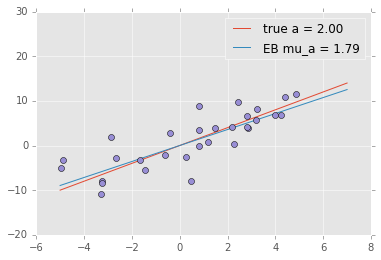

In [64]:
ys_eb = m_N * xs

plt.plot(xs, ys, label='true a = %.2f'%(a_orig))
plt.plot(xs, ys_eb, label='EB mu_a = %.2f'%(m_N))
plt.plot(data_x, data_y, 'o')
plt.ylim(-20, 30)
plt.legend()